In [1]:


import math
import pandas as pd
import numpy as np
from operator import itemgetter


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics


from sklearn import tree
from sklearn.tree import _tree

from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier 

from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import warnings
warnings.filterwarnings("ignore")


sns.set()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


INFILE = "C:\\Users\\Owner\\Documents\\Northwestern\\Intro_MachineLearning\\Unit1\\Lecture02B_MissingValueImputationForNumericVariables\\Insurance.csv"

TARGET_F = "TARGET_CLM_FLAG"
TARGET_A = "TARGET_CLM_AMT"

df = pd.read_csv( INFILE )

dt = df.dtypes
#print( dt )

objList = []
numList = []
for i in dt.index :
    #print(" here is i .....", i , " ..... and here is the type", dt[i] )
    if i in ( [ TARGET_F, TARGET_A ] ) : continue
    if dt[i] in (["object"]) : objList.append( i )
    if dt[i] in (["float64","int64"]) : numList.append( i )

In [2]:
"""
FILL IN MISSING WITH THE CATEGORY "MISSING"
"""
for i in objList :
    if df[i].isna().sum() == 0 : continue
    NAME = "IMP_"+i
    df[NAME] = df[i]
    df[NAME] = df[NAME].fillna("MISSING")
    g = df.groupby( NAME )
    df = df.drop( i, axis=1 )

dt = df.dtypes
objList = []
for i in dt.index :
    #print(" here is i .....", i , " ..... and here is the type", dt[i] )
    if i in ( [ TARGET_F, TARGET_A ] ) : continue
    if dt[i] in (["object"]) : objList.append( i )

In [3]:
'''
EXPLORE THE CATEGORICAL / OBJECT VARIABLES
'''
df["y_EDU_4"] = (df.EDUCATION.isin( ["a_PhD"] ) + 0 )
df["y_EDU_3"] = (df.EDUCATION.isin( ["a_PhD","b_Masters"] ) + 0)
df["y_EDU_2"] = (df.EDUCATION.isin( ["a_PhD","b_Masters","c_Bachelors"] ) + 0)
df["y_EDU_1"] = (df.EDUCATION.isin( ["a_PhD","b_Masters","c_Bachelors","d_High School"] ) + 0)
df = df.drop( "EDUCATION", axis=1 )
   

dt = df.dtypes
objList = []
for i in dt.index :
    #print(" here is i .....", i , " ..... and here is the type", dt[i] )
    if i in ( [ TARGET_F, TARGET_A ] ) : continue
    if dt[i] in (["object"]) : objList.append( i )


for i in objList :
    thePrefix = "z_" + i
    y = pd.get_dummies( df[i], prefix=thePrefix, drop_first=True )   
    #y = pd.get_dummies( df[i], prefix=thePrefix )   
    df = pd.concat( [df, y], axis=1 )
    #df = df.drop( i, axis=1 )


i = "INCOME"
FLAG = "M_" + i
IMP = "IMP_" + i
#print( i )
#print( FLAG )
#print( IMP )
df[ FLAG ] = df[i].isna() + 0
df[ IMP ] = df[ i ]
df.loc[ df[IMP].isna() & df["IMP_JOB"].isin(["Blue Collar"]), IMP ] = 53694
df.loc[ df[IMP].isna() & df["IMP_JOB"].isin(["Student"]), IMP ] = 360
df.loc[ df[IMP].isna() & df["IMP_JOB"].isin(["Clerical"]), IMP ] = 30799
df.loc[ df[IMP].isna() & df["IMP_JOB"].isin(["Doctor"]), IMP ] = 121398
df.loc[ df[IMP].isna() & df["IMP_JOB"].isin(["Home Maker"]), IMP ] = 776
df.loc[ df[IMP].isna() & df["IMP_JOB"].isin(["Lawyer"]), IMP ] = 83230
df.loc[ df[IMP].isna() & df["IMP_JOB"].isin(["MISSING"]), IMP ] = 109953
df.loc[ df[IMP].isna() & df["IMP_JOB"].isin(["Manager"]), IMP ] = 78589
df.loc[ df[IMP].isna() & df["IMP_JOB"].isin(["Professional"]), IMP ] = 71230
df.loc[ df[IMP].isna(), IMP ] = df[i].median()
df = df.drop( i, axis=1 )
numList.remove(i)


for i in numList :
    if df[i].isna().sum() == 0 : continue
    FLAG = "M_" + i
    IMP = "IMP_" + i
    #print(i)
    #print( df[i].isna().sum() )
    #print( FLAG )
    #print( IMP )
    #print(" ------- ")
    df[ FLAG ] = df[i].isna() + 0
    df[ IMP ] = df[ i ]
    df.loc[ df[IMP].isna(), IMP ] = df[i].median()
    df = df.drop( i, axis=1 )

In [4]:
"""
Remove Outliers
"""

dt = df.dtypes
numList = []
for i in dt.index :
    #print(i, dt[i])
    if i in ( [ TARGET_F, TARGET_A ] ) : continue
    if dt[i] in (["float64","int64"]) : numList.append( i )

for i in numList :
    theMean = df[i].mean()
    theSD = df[i].std()
    theMax = df[i].max()
    theCutoff = round( theMean + 3*theSD )
    if theMax < theCutoff : continue
    FLAG = "O_" + i
    TRUNC = "TRUNC_" + i
    df[ FLAG ] = ( df[i] > theCutoff )+ 0
    df[ TRUNC ] = df[ i ]
    df.loc[ df[TRUNC] > theCutoff, TRUNC ] = theCutoff
    df = df.drop( i, axis=1 )
    
for i in objList:
    df = df.drop( i, axis=1 )

In [5]:
"""
SPLIT DATA
"""

X = df.copy()
X = X.drop( TARGET_F, axis=1 )
X = X.drop( TARGET_A, axis=1 )

Y = df[ [TARGET_F, TARGET_A] ]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=1)
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2 )

##print( "FLAG DATA" )
##print( "TRAINING = ", X_train.shape )
##print( "TEST = ", X_test.shape )


F = ~ Y_train[ TARGET_A ].isna()
W_train = X_train[F].copy()
Z_train = Y_train[F].copy()

F = ~ Y_test[ TARGET_A ].isna()
W_test = X_test[F].copy()
Z_test = Y_test[F].copy()

#print( Z_train.describe() )
#print( Z_test.describe() )
#print( "\n\n")

F = Z_train[ TARGET_A ] > 25000
Z_train.loc[ F, TARGET_A ] = 25000

F = Z_test[ TARGET_A ] > 25000
Z_test.loc[ F, [TARGET_A] ] = 25000

#print( Z_train.describe() )
#print( Z_test.describe() )
#print( "\n\n")


##print( " ====== ")
##
##print( "AMOUNT DATA" )
##print( "TRAINING = ", W_train.shape )
##print( "TEST = ", Z_test.shape )

In [6]:
"""
MODEL ACCURACY METRICS
"""

def getProbAccuracyScores( NAME, MODEL, X, Y ) :
    pred = MODEL.predict( X )
    probs = MODEL.predict_proba( X )
    acc_score = metrics.accuracy_score(Y, pred)
    p1 = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve( Y, p1)
    auc = metrics.auc(fpr,tpr)
    return [NAME, acc_score, fpr, tpr, auc]

def print_ROC_Curve( TITLE, LIST ) :
    fig = plt.figure(figsize=(6,4))
    plt.title( TITLE )
    for theResults in LIST :
        NAME = theResults[0]
        fpr = theResults[2]
        tpr = theResults[3]
        auc = theResults[4]
        theLabel = "AUC " + NAME + ' %0.2f' % auc
        plt.plot(fpr, tpr, label = theLabel )
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def print_Accuracy( TITLE, LIST ) :
    print( TITLE )
    print( "======" )
    for theResults in LIST :
        NAME = theResults[0]
        ACC = theResults[1]
        print( NAME, " = ", ACC )
    print( "------\n\n" )

def getAmtAccuracyScores( NAME, MODEL, X, Y ) :
    pred = MODEL.predict( X )
    MEAN = Y.mean()
    RMSE = math.sqrt( metrics.mean_squared_error( Y, pred))
    return [NAME, RMSE, MEAN]

In [7]:
##"""
##DECISION TREE
##"""

def getTreeVars( TREE, varNames ) :
    tree_ = TREE.tree_
    varName = [ varNames[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature ]

    nameSet = set()
    for i in tree_.feature :
        if i != _tree.TREE_UNDEFINED :
            nameSet.add( i )
    nameList = list( nameSet )
    parameter_list = list()
    for i in nameList :
        parameter_list.append( varNames[i] )
    return parameter_list

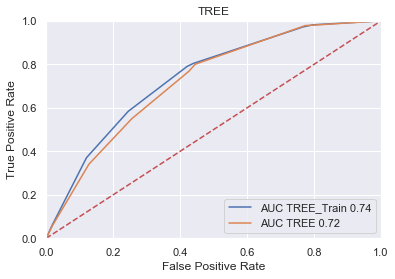

TREE CLASSIFICATION ACCURACY
TREE_Train  =  0.7440844557699309
TREE  =  0.730228044638525
------


y_EDU_2
z_PARENT1_Yes
TRUNC_OLDCLAIM
z_URBANICITY_Highly Urban/ Urban
TRUNC_KIDSDRIV


In [12]:
# CRASH PROBABILITY

WHO = "TREE"

CLM = tree.DecisionTreeClassifier( max_depth=3 )
CLM = CLM.fit( X_train, Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

feature_cols = list( X.columns.values )
tree.export_graphviz(CLM,out_file='tree_f.txt',filled=True, rounded=True, feature_names = feature_cols, impurity=False, class_names=["Good","Bad"]  )
vars_tree_flag = getTreeVars( CLM, feature_cols ) 

for i in vars_tree_flag :
    print(i)

In [11]:
# DAMAGES

AMT = tree.DecisionTreeRegressor( max_depth= 4 )
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

feature_cols = list( X.columns.values )
vars_tree_amt = getTreeVars( AMT, feature_cols ) 
tree.export_graphviz(AMT,out_file='tree_a.txt',filled=True, rounded=True, feature_names = feature_cols, impurity=False, precision=0  )

for i in vars_tree_amt :
    print(i)


TREE_CLM = TEST_CLM.copy()
TREE_AMT = TEST_AMT.copy()

TREE RMSE ACCURACY
TREE_Train  =  4644.113464203337
TREE  =  4644.597987846525
------


TRUNC_BLUEBOOK
z_MSTATUS_Yes
TRUNC_TIF
z_CAR_USE_Private
z_CAR_TYPE_SUV
O_IMP_INCOME
TRUNC_IMP_AGE
TRUNC_IMP_YOJ
TRUNC_IMP_HOME_VAL


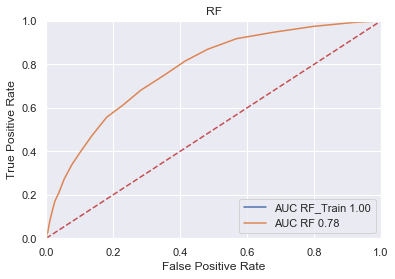

RF CLASSIFICATION ACCURACY
RF_Train  =  0.9978157990535129
RF  =  0.7671033478893741
------


('TRUNC_BLUEBOOK', 100)
('TRUNC_IMP_INCOME', 95)
('TRUNC_TRAVTIME', 90)
('TRUNC_IMP_AGE', 89)
('TRUNC_IMP_HOME_VAL', 80)
('TRUNC_OLDCLAIM', 74)
('TRUNC_MVR_PTS', 73)
('TRUNC_IMP_CAR_AGE', 62)
('TRUNC_CLM_FREQ', 60)
('TRUNC_IMP_YOJ', 60)
('z_URBANICITY_Highly Urban/ Urban', 55)
('TRUNC_TIF', 54)
('TRUNC_NPOLICY', 32)
('TRUNC_HOMEKIDS', 31)
('z_REVOKED_Yes', 25)
('z_CAR_USE_Private', 25)


In [13]:
"""
RANDOM FOREST
"""


def getEnsembleTreeVars( ENSTREE, varNames ) :
    importance = ENSTREE.feature_importances_
    index = np.argsort(importance)
    theList = []
    for i in index :
        imp_val = importance[i]
        if imp_val > np.average( ENSTREE.feature_importances_ ) :
            v = int( imp_val / np.max( ENSTREE.feature_importances_ ) * 100 )
            theList.append( ( varNames[i], v ) )
    theList = sorted(theList,key=itemgetter(1),reverse=True)
    return theList

WHO = "RF"

CLM = RandomForestClassifier( n_estimators = 25, random_state=1 )
CLM = CLM.fit( X_train, Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )


feature_cols = list( X.columns.values )
vars_RF_flag = getEnsembleTreeVars( CLM, feature_cols )

for i in vars_RF_flag :
    print(i)

In [14]:
# DAMAGES

AMT = RandomForestRegressor(n_estimators = 100, random_state=1)
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

feature_cols = list( X.columns.values )
vars_RF_amt = getEnsembleTreeVars( AMT, feature_cols )

for i in vars_RF_amt :
   print( i )

RF_CLM = TEST_CLM.copy()
RF_AMT = TEST_AMT.copy()

RF RMSE ACCURACY
RF_Train  =  1854.5793037265098
RF  =  4662.62690093848
------


('TRUNC_BLUEBOOK', 100)
('TRUNC_TRAVTIME', 62)
('TRUNC_IMP_INCOME', 59)
('TRUNC_IMP_AGE', 55)
('TRUNC_OLDCLAIM', 40)
('TRUNC_IMP_HOME_VAL', 40)
('TRUNC_IMP_YOJ', 33)
('TRUNC_IMP_CAR_AGE', 32)
('TRUNC_TIF', 27)
('TRUNC_MVR_PTS', 27)
('TRUNC_NPOLICY', 19)
('TRUNC_HOMEKIDS', 18)
('TRUNC_CLM_FREQ', 17)


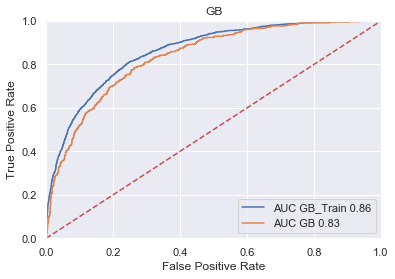

GB CLASSIFICATION ACCURACY
GB_Train  =  0.815556364518869
GB  =  0.7942746239689471
------


('TRUNC_OLDCLAIM', 100)
('z_URBANICITY_Highly Urban/ Urban', 85)
('y_EDU_2', 40)
('z_CAR_USE_Private', 36)
('TRUNC_KIDSDRIV', 29)
('TRUNC_IMP_HOME_VAL', 27)
('TRUNC_MVR_PTS', 26)
('TRUNC_BLUEBOOK', 25)
('TRUNC_IMP_AGE', 25)
('TRUNC_IMP_INCOME', 24)
('z_REVOKED_Yes', 23)
('z_PARENT1_Yes', 21)
('TRUNC_TRAVTIME', 20)
('z_IMP_JOB_Manager', 15)
('TRUNC_TIF', 12)
('z_MSTATUS_Yes', 11)


In [15]:
"""
GRADIENT BOOSTING
"""

WHO = "GB"

CLM = GradientBoostingClassifier( random_state=1 )
CLM = CLM.fit( X_train, Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )


feature_cols = list( X.columns.values )
vars_GB_flag = getEnsembleTreeVars( CLM, feature_cols )

for i in vars_GB_flag :
    print(i)

In [16]:
# DAMAGES

AMT = GradientBoostingRegressor(random_state=1)
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

feature_cols = list( X.columns.values )
vars_GB_amt = getEnsembleTreeVars( AMT, feature_cols )

for i in vars_RF_amt :
   print( i )

GB_CLM = TEST_CLM.copy()
GB_AMT = TEST_AMT.copy()

GB RMSE ACCURACY
GB_Train  =  4088.4205986311904
GB  =  4663.5831314824145
------


('TRUNC_BLUEBOOK', 100)
('TRUNC_TRAVTIME', 62)
('TRUNC_IMP_INCOME', 59)
('TRUNC_IMP_AGE', 55)
('TRUNC_OLDCLAIM', 40)
('TRUNC_IMP_HOME_VAL', 40)
('TRUNC_IMP_YOJ', 33)
('TRUNC_IMP_CAR_AGE', 32)
('TRUNC_TIF', 27)
('TRUNC_MVR_PTS', 27)
('TRUNC_NPOLICY', 19)
('TRUNC_HOMEKIDS', 18)
('TRUNC_CLM_FREQ', 17)
